In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import preprocessing
import air_traff_utils as atu
import geopandas as gpd
import ipdb
import warnings
warnings.filterwarnings('ignore')


In [2]:
atu.setup_seed(12)

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [4]:
us_CSA = pd.read_csv('./data/us_CSA.csv', index_col=0)
OD_df = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)
CSA_df = pd.read_csv('./data/CSA_df.csv')

In [5]:
combined_airports3 = ['NYC', 'WAS']
OD_df.loc[combined_airports3] = OD_df.loc[combined_airports3]/3
OD_df[combined_airports3] = OD_df[combined_airports3]/3
OD_df.loc[combined_airports3, combined_airports3] = OD_df.loc[combined_airports3, combined_airports3]*3

combined_airports2 = ['CHI', 'MIA']
OD_df.loc[combined_airports2] = OD_df.loc[combined_airports2]/2
OD_df[combined_airports2] = OD_df[combined_airports2]/2
OD_df.loc[combined_airports2, combined_airports2] = OD_df.loc[combined_airports2, combined_airports2]*2


In [6]:
# normalize OD
scalar_OD = preprocessing.MinMaxScaler().fit(OD_df.to_numpy().reshape(-1, 1))
OD_df_values = scalar_OD.transform(OD_df.to_numpy().reshape(-1, 1)).reshape(24, 24)
OD_df = pd.DataFrame(OD_df_values, index=OD_df.index, columns=OD_df.columns)

In [7]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [8]:
data_X = pd.DataFrame(us_CSA_use.copy().drop(['CSA', 'CBSA', 'CBSA_Name', 'INTPTLAT', 'INTPTLON', 'geometry', 'if_plot'], axis=1))
data_X.index = range(data_X.shape[0])

In [9]:
data_X['CSA_Code'] = ''
for i in data_X.index:
    CSA_Name = data_X.loc[i, 'CSA_Name']
    data_X.loc[i, 'CSA_Code'] = CSA_df.loc[CSA_df['CSA_Name']==CSA_Name, 'Airport'].values[0]

print(data_X.shape)
data_X.head(2)

(24, 20)


,TotPop,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,E_HiWageWk,D1B,D1C,D3A,D4A,D4B050,D4C,D4D,D5AR,D5AE,NatWalkInd,CSA_Name,CSA_Code
0,6584708,142257,759558,1449909,2970375,668868,969644,1331863,4.184264,2.193174,11.808044,-67955.508346,0.026778,-60276.863137,-60268.179268,310871248,224466891,8.498581,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,349774,1079810,1704849,3823517,825804,1051349,1946364,13.357811,5.484528,18.586822,-39255.813819,0.150468,-28799.664050,-28642.284283,646668796,596458073,11.342761,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


In [10]:
data_X = data_X.drop(['D4C', 'AutoOwn0', 'AutoOwn1', 'AutoOwn2p', 'TotEmp', 'E_LowWageW', 'E_MedWageW', 'E_HiWageWk', 'D1B', 'D1C', 'D4D', 'D4B050', 'D5AE', 'D5AR', 'NatWalkInd'], axis=1)
print(data_X.shape)
data_X.head(2)
att_lst = data_X.iloc[:, :data_X.shape[0]-2].columns
print(att_lst)
data_X.head(2)

(24, 5)
Index(['TotPop', 'D3A', 'D4A', 'CSA_Name', 'CSA_Code'], dtype='object')


,TotPop,D3A,D4A,CSA_Name,CSA_Code
0,6584708,11.808044,-67955.508346,"Atlanta--Athens-Clarke County--Sandy Springs, ...",ATL
1,8200935,18.586822,-39255.813819,"Boston-Worcester-Providence, MA-RI-NH-CT",BOS


In [11]:
data_X.index = data_X['CSA_Code']
data_X.loc[combined_airports3, ['TotPop', 'D3A', 'D4A']] = data_X.loc[combined_airports3, ['TotPop', 'D3A', 'D4A']]/3
data_X.loc[combined_airports2, ['TotPop', 'D3A', 'D4A']] = data_X.loc[combined_airports2, ['TotPop', 'D3A', 'D4A']]/2
data_X.index = range(data_X.shape[0])


In [12]:
# standardize data_X
data_X_f = data_X.loc[:, ['TotPop', 'D3A', 'D4A']]
scalar_data_X_feature = preprocessing.StandardScaler().fit(np.array(data_X_f))
data_X.loc[:, ['TotPop', 'D3A', 'D4A']] = scalar_data_X_feature.transform(np.array(data_X_f))


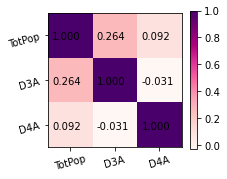

In [13]:
plt.figure(figsize=[3, 3])
heat_plot_data_X = data_X.iloc[:, :3]
plt.imshow(heat_plot_data_X.corr(), cmap='RdPu')
for i in range(3):  # 1 features, number may subject to change
    for j in range(3):
        plt.text(i-0.4, j+0.1, '%.3f'%(heat_plot_data_X.corr().iloc[i, j]))
plt.xticks(range(3), list(heat_plot_data_X.columns), rotation = 15)
plt.yticks(range(3), list(heat_plot_data_X.columns), rotation = 15)
plt.colorbar(shrink=0.85)

(24, 24)


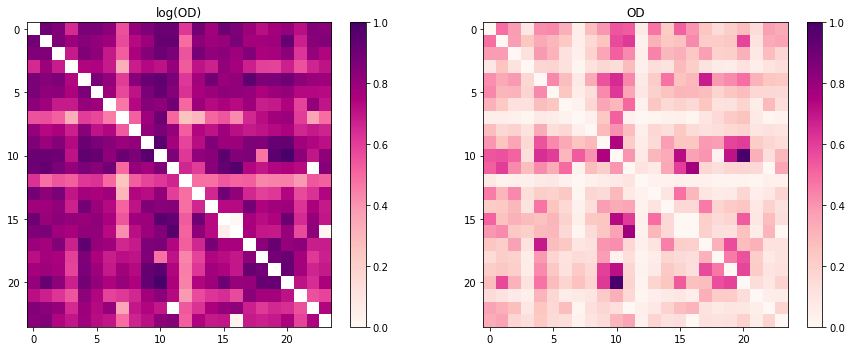

In [14]:
# visualization OD
print(OD_df.shape)
fig = plt.figure(figsize=[15,7])

ax1 = fig.add_subplot(121)
ax1.imshow(np.log(OD_df), cmap='RdPu')
ax1.set_title('log(OD)')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax1, shrink=0.8)

ax2 = fig.add_subplot(122)
ax2.imshow(OD_df, cmap='RdPu')
ax2.set_title('OD')
fig.colorbar(cm.ScalarMappable(cmap='RdPu'), ax=ax2, shrink=0.8)

# Prepare Feature Pairs (X)

In [15]:
def get_logOD(OD):
    # OD is originally DataFrame
    OD = np.array(OD)
    for i in range(OD.shape[0]):
        for j in range(OD.shape[1]):
            if OD[i, j]!=0:
                OD[i, j] = np.log(OD[i, j])
    return OD

In [16]:
data_X = np.array(data_X.iloc[:, :3])
# scalar_data_X = preprocessing.StandardScaler().fit(data_X)
# data_X = scalar_data_X.transform(data_X)  # shape: [num_cities * num_features*2+1, 1]
print('data_X | Shape:', data_X.shape, ', type: %s'%type(data_X))

OD = np.array(OD_df)  # shape: [num_cities, num_cities]
OD = OD.reshape(-1, 1)
scalar_OD = preprocessing.MinMaxScaler().fit(OD)
OD = scalar_OD.transform(OD)
print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

data_X | Shape: (24, 3) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


In [17]:
print(us_CSA_use.shape)
us_CSA_use.head(2)


(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
6,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.165852 32.808496999999996, -85.1..."
13,8200935,148.0,49340.0,"Worcester, MA-CT",349774,1079810,1704849,3823517,825804,1051349,...,-28799.664050,-28642.284283,646668796,596458073,11.342761,42.293282,-71.237945,"Boston-Worcester-Providence, MA-RI-NH-CT",1,"MULTIPOLYGON (((-71.883921 41.326498, -71.8821..."


In [18]:
att_lst

Index(['TotPop', 'D3A', 'D4A', 'CSA_Name', 'CSA_Code'], dtype='object')

In [19]:
# 24代表了24个机场，9代表了9个特征，
# OD是要预测的对象（y）
# 现在要把变成 X【576,19】，where 576=24*24,19=2*9+1
# 2*9代表出发地和目的地各有9个特征，1代表两地之间的特征
# 因为目的是要训练一个函数 f：X->y
# 也就是说输入【576,19】，输出【576,1】
# Write your code here...

data_X_distance = pd.DataFrame(us_CSA_use.copy()[['INTPTLAT','INTPTLON']])
data_X_distance = data_X_distance.reset_index().drop(['index'],axis = 1)

from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

a = pd.DataFrame(data_X)

X = pd.DataFrame()
X[0] = a.T[0].append(a.T[1])

X = pd.DataFrame()
for i in range(24):
    for j in range(24):
        X[i*24+j] = a.T[i].append(a.T[j])

X = X.reset_index().drop(['index'],axis = 1).T

col_19 = []
for i in range(24):
    for j in range(24):
        lat1 = data_X_distance.iloc[i,0]
        lon1 = data_X_distance.iloc[i,1]
        lat2 = data_X_distance.iloc[j,0]
        lon2 = data_X_distance.iloc[j,1]
        col_19.append(distance(lat1, lat2, lon1, lon2))
X['9'] = col_19


In [20]:
X = np.array(X)
# scalar_X = preprocessing.MinMaxScaler().fit(X)
# X = scalar_X.transform(X)  # shape: [num_cities^2, 19]
print('X | Shape:', X.shape, ', type: %s'%type(X))


print('OD | Shape:', OD.shape, ', type: %s'%type(OD))

X | Shape: (576, 7) , type: <class 'numpy.ndarray'>
OD | Shape: (576, 1) , type: <class 'numpy.ndarray'>


# Define Gravity Model

In [21]:
# Model specification
class DeepGravityNet(nn.Module):
    def __init__(self, inp_dim, hid_dim=256, out_dim=1, dropout_p=0.3):
        super(DeepGravityNet, self).__init__()
        
        self.deep_graivty_fc1 = nn.Sequential(
            nn.Linear(inp_dim, out_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout_p),
        )
        
    def forward(self, x):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        y = self.deep_graivty_fc1(x)
        return y
    

# Preparing Data for Pytorch

In [22]:
# #############################
# Preparing data for PyTorch
# #############################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# prop = 14/24
# l = int(576*prop)

X = X.reshape(24, 24, 7)
X_train = X[:14,:14,:].reshape(-1, 7)
X_val = X[14:,14:,:].reshape(-1, 7)

OD = OD.reshape(24, 24)
y_train = OD[:14,:14].reshape(-1, 1)
y_val = OD[14:,14:].reshape(-1, 1)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

batch_size = 2500
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)

iter_train = iter(loader_train)


In [23]:
print('X_train', type(X_train), X_train.shape)
print('y_train', type(y_train), y_train.shape)
print('X_val', type(X_val), X_val.shape)
print('y_val', type(y_val), y_val.shape)

X_train <class 'torch.Tensor'> torch.Size([196, 7])
y_train <class 'torch.Tensor'> torch.Size([196, 1])
X_val <class 'torch.Tensor'> torch.Size([100, 7])
y_val <class 'torch.Tensor'> torch.Size([100, 1])


# Initialize the Model

In [24]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
inp_dim = X.shape[-1]
model = DeepGravityNet(inp_dim).to(device)
loss_func = nn.MSELoss()  # reconstruction loss function

loss_set_train = []
loss_set_val = []

print('There are %i OD pairs for training'%X_train.shape[0])


There are 196 OD pairs for training


# Train the Model

In [25]:
optimizer = optim.Adam(model.parameters())

In [26]:
out = model(X_train)

In [27]:
model.train()

epochs = 1000

# assert len(src_loader) == len(tar_loader)
   
for e in range(epochs+1):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X, y = iter_train.next()
        except:
            iter_train = iter(loader_train)
            X, y = iter_train.next()
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        out_val = model(X_val)
#         ipdb.set_trace()
        loss_val = loss_func(out_val, y_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        

Epoch 0   success, val loss:0.157245, train loss:0.143921
Epoch 50   success, val loss:0.103629, train loss:0.090873
Epoch 100   success, val loss:0.070204, train loss:0.071626
Epoch 150   success, val loss:0.058026, train loss:0.062034
Epoch 200   success, val loss:0.050828, train loss:0.061203
Epoch 250   success, val loss:0.047870, train loss:0.057649
Epoch 300   success, val loss:0.049725, train loss:0.057946
Epoch 350   success, val loss:0.046234, train loss:0.049482
Epoch 400   success, val loss:0.041460, train loss:0.050419
Epoch 450   success, val loss:0.039522, train loss:0.057552
Epoch 500   success, val loss:0.035968, train loss:0.050564
Epoch 550   success, val loss:0.040885, train loss:0.057373
Epoch 600   success, val loss:0.033296, train loss:0.047666
Epoch 650   success, val loss:0.036475, train loss:0.061412
Epoch 700   success, val loss:0.032979, train loss:0.049042
Epoch 750   success, val loss:0.039539, train loss:0.058395
Epoch 800   success, val loss:0.039530, tra

In [28]:
def plot_loss(val, train, title):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.plot(val)
    ax1.set_xlabel('Batches')
    ax1.set_ylabel('MSELoss')
    ax1.set_ylim([0, max(val)])
    ax1.set_title('Validation loss')
    ax1.grid()
    ax2 = fig.add_subplot(122)
    ax2.plot(train)
    ax2.set_xlabel('Batches')
    ax2.set_ylabel('MSELoss')
    ax2.set_ylim([0, max(train)])
    ax2.set_title('Train loss')
    ax2.grid()
    plt.suptitle(title)

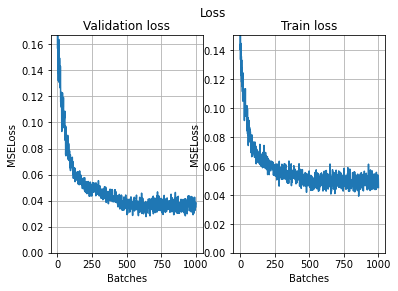

In [29]:
plot_loss(loss_set_val, loss_set_train, 'Loss')

In [34]:
pred = out_val.cpu().detach().numpy()[:650, :]

labels = y_val.cpu().detach().numpy()[:650, :]

m = 0.0

print('The mae loss is %.4f'%atu.mae_loss_func(pred, labels, m))
print('The mape loss is %.4f'%atu.mape_loss_func(pred, labels, m))
print('The smape loss is %.4f'%atu.smape_loss_func(pred, labels, m))
print('The nrmse loss is %.4f'%atu.nrmse_loss_func(pred, labels, m))
print('The nmae loss is %.4f'%atu.nmae_loss_func(pred, labels, m))
print('CPC is %.5f'%atu.get_CPC(pred, labels))


The mae loss is 0.1424
The mape loss is 12.5244
The smape loss is 0.7899
The nrmse loss is 0.2914
The nmae loss is 0.2423
CPC is 0.56236


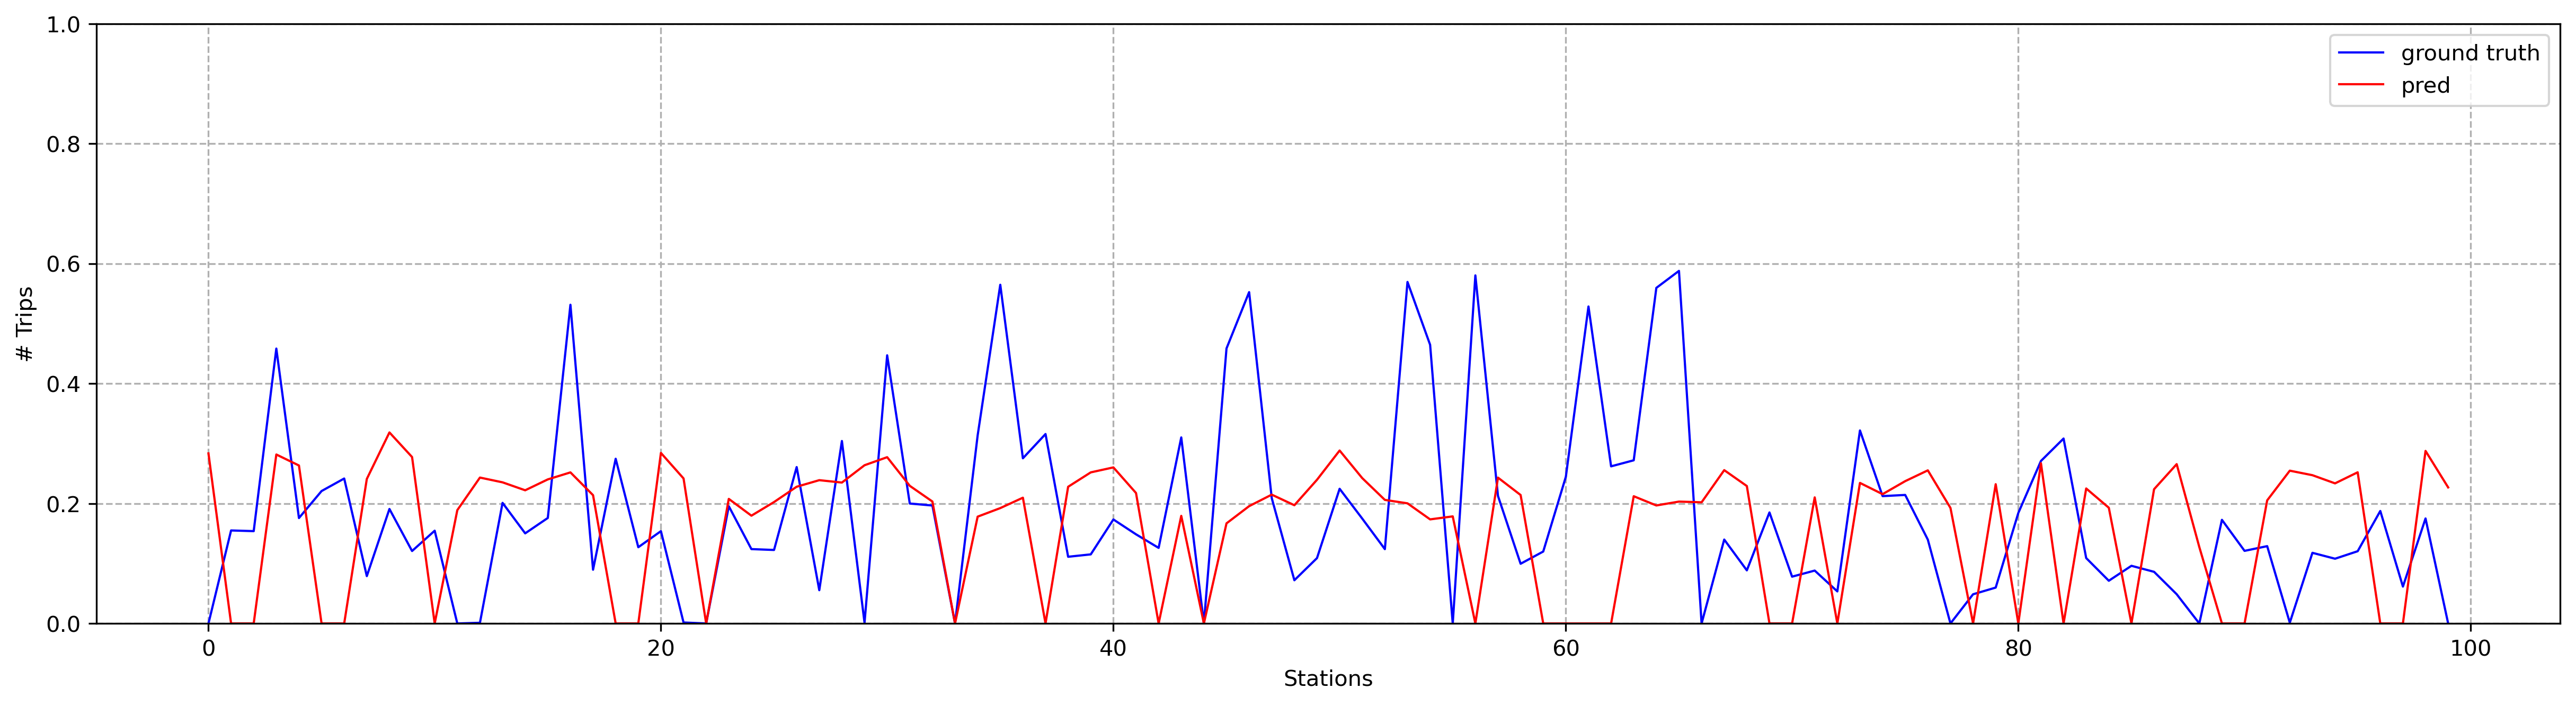

In [35]:
plt.figure(figsize=[20,5], dpi=300)
plt.plot(y_val.cpu().detach().numpy()[:650, 0], 'b', label='ground truth', lw=1)
plt.plot(out_val.cpu().detach().numpy()[:650, 0], 'r', label='pred', lw=1)
plt.xlabel('Stations')
plt.ylabel('# Trips')
plt.ylim([0,1])
plt.legend()
plt.grid(ls='--')

In [36]:
# np.save('./res/mfg_labels.npy', y_val.cpu().detach().numpy())
# np.save('./res/mfg_pred.npy', out_val.cpu().detach().numpy())

In [37]:
# np.save('./res/mfg_input.npy', np.array(X_val.cpu().detach().numpy()))